In [1]:
# Sean Dougherty
# 03/15/2022
# this file reads in the output csv filed from agn_merger.py and does some preliminary visualization
# will later become a .py file for sharing and convinience

In [ ]:
# at the end of csv processing, we want a df with bins as columns and iterations as rows
# we want 3 of these: for pair AGN fraction, iso AGN fraction, and enhancement

In [2]:
# load libraries
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import os

from time import sleep
from tqdm import tqdm

from multiprocessing import Pool, freeze_support, RLock

data_path = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'

## Checking pair and control galaxy mass and redshift distributions

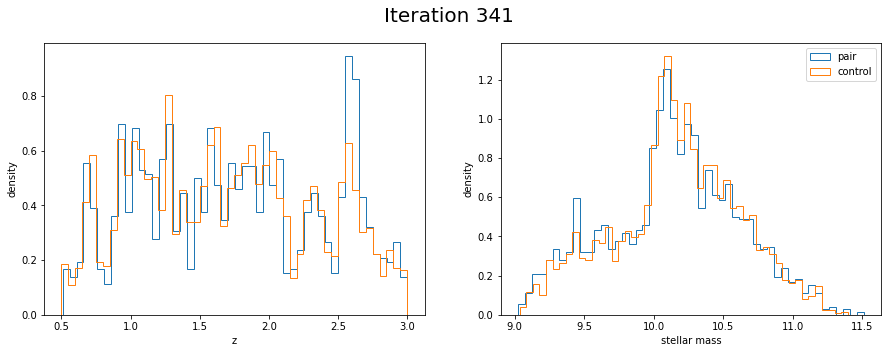

1.74 1.66


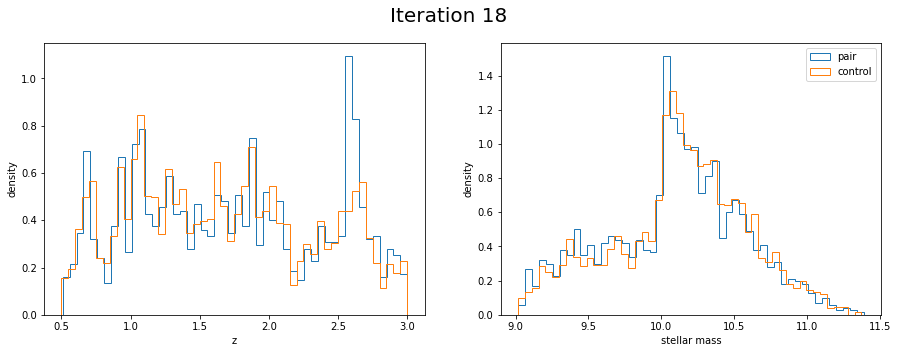

1.7 1.63


In [314]:
# do I want to do this by bin? or per iteration?
# probably best to just randomly choose 2 or 3 iterations to look at this for

#photo-specz_results/photo-specz_'

# photo-specz_5.csv
# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
# data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
data_path2 = 'photoz_results/'


# generate a 2 random integers to look at distributions
idx = random.randint(len(os.listdir(data_path+data_path2)), size=2)


# open each dataframe and plot distributions
for file_idx in idx:
    ran_df = pd.read_csv( data_path+data_path2+(os.listdir(data_path+data_path2))[file_idx] )
    ran_df = ran_df[ (ran_df['prime_drawn_M'] > 10) ]#& (ran_df['field'] != 'GDS') ]
    
    # create arrays for distributions
    histp_z = np.concatenate( (np.array(ran_df['prime_drawn_z']), np.array(ran_df['partner_drawn_z'])), axis=0 )
    histp_M = np.concatenate( (np.array(ran_df['prime_drawn_M']), np.array(ran_df['partner_drawn_M'])), axis=0 )
    
    histc_z = np.concatenate( (np.array(ran_df['prime_control1_drawn_z']), np.array(ran_df['prime_control2_drawn_z']),
                               np.array(ran_df['partner_control1_drawn_z']), np.array(ran_df['partner_control2_drawn_z'])), axis=0 )
    histc_M = np.concatenate( (np.array(ran_df['prime_control1_drawn_M']), np.array(ran_df['prime_control2_drawn_M']),
                               np.array(ran_df['partner_control1_drawn_M']), np.array(ran_df['partner_control2_drawn_M'])), axis=0 )
    
    # make subplots to show mass and z distributions for pair and control galaxies
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    axs[0].hist(histp_z, bins=50, density=True, histtype='step')
    axs[0].hist(histc_z, bins=50, density=True, histtype='step')
    axs[0].set_xlabel('z')
    axs[0].set_ylabel('density')
    #axs[0].title['redshift']
    
    axs[1].hist(histp_M, bins=50, density=True, histtype='step', label='pair')
    axs[1].hist(histc_M, bins=50, density=True, histtype='step', label='control')
    axs[1].legend()
    axs[1].set_xlabel('stellar mass')
    axs[1].set_ylabel('density')
    
    fig.suptitle('Iteration {}'.format(file_idx), fontsize=20)
    
    #axs[1].title('iteration '+str(file_idx))
    plt.show()
    
    print( np.median(histp_z), np.nanmedian(histc_z) )

In [265]:
ran_df

,Unnamed: 0,prime_index,partner_index,arc_sep,mass_ratio,dv,kpc_sep,prime_drawn_z,prime_drawn_M,prime_drawn_LX,partner_drawn_z,partner_drawn_M,partner_drawn_LX,prime_control1_ID,prime_control1_drawn_z,prime_control1_drawn_M,prime_control1_drawn_LX,prime_control2_ID,prime_control2_drawn_z,prime_control2_drawn_M,prime_control2_drawn_LX,partner_control1_ID,partner_control1_drawn_z,partner_control1_drawn_M,partner_control1_drawn_LX,partner_control2_ID,partner_control2_drawn_z,partner_control2_drawn_M,partner_control2_drawn_LX,field,prime_cat_ID,partner_cat_ID,prime_control1_cat_ID,prime_control2_cat_ID,partner_control1_cat_ID,partner_control2_cat_ID
45,10719,448,444,1.201206,0.160000,0.000000,8.377475,0.66,10.290000,-1.861316e+59,0.6600,10.130000,-1.861316e+59,15625.0,0.6800,10.290000,-2.002033e+59,6760.0,0.68,10.290000,-2.002033e+59,3337.0,0.66,10.110000,-1.861316e+59,5791.0,0.67,10.150000,-1.930892e+59,GDS,610,606,23633.0,9958.0,4773.0,8512.0
58,15491,645,658,10.636109,0.610000,-417.351918,84.547914,2.67,10.180000,-5.776980e+60,2.6900,9.570000,-5.882198e+60,12965.0,2.6800,10.180000,-5.829454e+60,15408.0,2.67,10.200000,-5.776980e+60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GDS,887,905,19580.0,23333.0,NaN,NaN
59,15497,645,716,11.658187,0.940000,-828.581980,92.672552,2.67,10.180000,-5.776980e+60,2.7100,9.240000,-5.988494e+60,14276.0,2.6686,10.160000,-5.267007e+60,821.0,2.69,10.170000,-5.882198e+60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GDS,887,982,21640.0,1132.0,NaN,NaN
69,18120,754,677,7.218456,0.570000,-186.101377,60.864399,1.84,10.030000,-2.330815e+60,1.8445,9.460000,-5.697493e+59,11376.0,1.8600,10.010000,-2.393493e+60,7383.0,1.81,10.070000,-2.238601e+60,15002.0,1.85,9.450000,-2.362034e+60,6714.0,1.83,9.480000,-2.299837e+60,GDS,1033,931,17157.0,10908.0,22700.0,9885.0
82,23059,956,1033,10.258567,0.760000,0.000000,82.577973,2.53,10.990000,-5.070494e+60,2.5300,10.230000,-5.070494e+60,653.0,2.5400,10.980000,-5.119224e+60,1409.0,2.54,11.000000,-5.119224e+60,15524.0,2.55,10.160000,-5.168219e+60,16833.0,2.54,10.310000,-5.119224e+60,GDS,1329,1434,899.0,1975.0,23486.0,25459.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10428,649369,18971,19155,1.229924,0.691671,500.818722,10.417839,1.64,11.071882,4.939066e+43,1.6300,10.380211,-1.730085e+60,9936.0,1.6300,11.049218,-1.730085e+60,13266.0,1.60,11.079181,-1.652675e+60,16820.0,1.62,10.367356,-1.704052e+60,12611.0,1.63,10.399674,-1.730085e+60,UDS,26373,26636,13729.0,18285.0,23238.0,17403.0
10439,652552,19068,19190,1.538478,0.090709,-515.311497,13.032871,1.60,10.053078,-1.652675e+60,1.6100,9.962369,-1.678249e+60,18966.0,1.5800,10.056905,-1.602216e+60,19205.0,1.57,10.041393,-1.577329e+60,15477.0,1.63,9.983175,-1.730085e+60,9892.0,1.60,9.997386,-1.652675e+60,UDS,26515,26680,26364.0,26696.0,21377.0,13680.0
10453,657406,19221,19178,3.331600,0.289502,0.000000,26.679364,1.00,10.931966,-5.170847e+59,1.0000,10.642465,-5.170847e+59,11634.0,0.9800,10.932981,-4.918954e+59,10336.0,0.98,10.957128,-4.918954e+59,17963.0,1.02,10.658011,-5.430338e+59,15483.0,1.03,10.622214,-5.562953e+59,UDS,26717,26665,16065.0,14290.0,24934.0,21385.0
10483,666446,19491,16885,2.800840,0.917091,-464.606625,23.702863,1.71,10.462398,-1.946697e+60,1.7200,9.545307,-1.974825e+60,16362.0,1.7100,10.442480,-1.946697e+60,18704.0,1.73,10.442480,-2.003187e+60,5711.0,1.69,9.562293,-1.891146e+60,318.0,1.69,9.583199,-1.891146e+60,UDS,27088,23324,22634.0,25980.0,8045.0,520.0


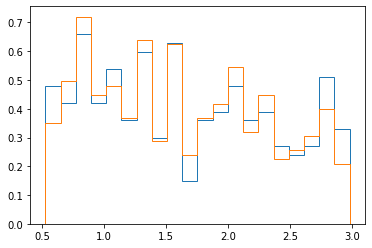

In [238]:
# test_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/photoz_TEST.csv')
ran_df = ran_df[ ran_df['kpc_sep'] < 20 ]
pairz = np.concatenate( (np.array(ran_df['prime_drawn_z']), np.array(ran_df['partner_drawn_z'])), axis=0 )
isoz =  np.concatenate( (np.array(ran_df['prime_control1_drawn_z']), np.array(ran_df['prime_control2_drawn_z']),
                       np.array(ran_df['partner_control1_drawn_z']), np.array(ran_df['partner_control2_drawn_z'])), axis=0 )
pairm = np.concatenate( (np.array(ran_df['prime_drawn_M']), np.array(ran_df['partner_drawn_M'])), axis=0 )
isom =  np.concatenate( (np.array(ran_df['prime_control1_drawn_M']), np.array(ran_df['prime_control2_drawn_M']),
                       np.array(ran_df['partner_control1_drawn_M']), np.array(ran_df['partner_control2_drawn_M'])), axis=0 )
x, bins, patches = plt.hist(pairz, bins=20, density=True, histtype='step')
plt.hist(isoz, bins=bins, density=True, histtype='step')
plt.show()

In [1]:
ran_df2 = ran_df[ (ran_df['prime_drawn_LX'] > 42) ]
ran_df3 = ran_df[ (ran_df['partner_drawn_LX'] > 42) ]

ran_df4 = ran_df[ (ran_df['prime_control1_drawn_LX'] > 42) ]
ran_df5 = ran_df[ (ran_df['prime_control2_drawn_LX'] > 42) ]
ran_df6 = ran_df[ (ran_df['partner_control1_drawn_LX'] > 42) ]
ran_df7 = ran_df[ (ran_df['partner_control2_drawn_LX'] > 42) ]

# print(ran_df2['prime_index'])
# print(ran_df3['partner_index'])
# print(ran_df4['prime_control1_ID'])
# print(ran_df5['prime_control2_ID'])
# print(ran_df6['partner_control1_ID'])
# print(ran_df7['partner_control2_ID'])


NameError: name 'ran_df' is not defined

## Pair/Control z and mass distributions over all iteration

In [3]:
# loop through all files in directory
# keep appending the mass and redshift values -> in each bin though
# take median / mean at the end
# compliment with some kind of LX distrubutions at different mass or redshifts

In [186]:
# get the bin information -> only really need 'bins'
max_dist=100
n_bins=8
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# create dictionaries for isolated / control mass / z arrays
im_dict = {}
iz_dict = {}
pm_dict = {}
pz_dict = {}

# AGN frequency ideally peaks around z=2 -> are there more AGN in galaxies at higher redshifts?
# to test this, let's keep track of (z, LX) across all iterations -> all together now
AGN_z = []
AGN_LX = []

# loop throug the bins to create empty lists to append to
for rnge in bins:
    im_dict[bins[rnge]] = []
    iz_dict[bins[rnge]] = []
    pm_dict[bins[rnge]] = []
    pz_dict[bins[rnge]] = []
    
# agn_merger.py outputs:
data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
# data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
# data_path2 = 'photoz_results/'

# read through all the iteration files
for file in tqdm(os.listdir(data_path+data_path2)):
    it_df = pd.read_csv(data_path+data_path2+file)
    it_df = it_df[ (it_df['prime_drawn_M'] > 10) & (it_df['prime_drawn_z'] < 3.0) & (it_df['field'] != 'GDS') ]# &
                #(it_df['mass_ratio'] <= 0.40)]
        
    # append AGN z and LX values
    AGN_z.append( np.array( it_df.loc[it_df['prime_drawn_LX'] > 42, 'prime_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_drawn_LX'] > 42, 'partner_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['prime_control1_drawn_LX'] > 42, 'prime_control1_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['prime_control2_drawn_LX'] > 42, 'prime_control2_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_control1_drawn_LX'] > 42, 'partner_control1_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_control2_drawn_LX'] > 42, 'partner_control2_drawn_z'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_drawn_LX'] > 42, 'prime_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_drawn_LX'] > 42, 'partner_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_control1_drawn_LX'] > 42, 'prime_control1_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_control2_drawn_LX'] > 42, 'prime_control2_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_control1_drawn_LX'] > 42, 'partner_control1_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_control2_drawn_LX'] > 42, 'partner_control2_drawn_LX'] ) )
                 
    
    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])
        
        # sort into bins
        bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]
        
        # append all mass and z values to appropriate dictionaries
        im_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_control1_drawn_M']), np.array(bin_df['prime_control2_drawn_M']),
                                   np.array(bin_df['partner_control1_drawn_M']), np.array(bin_df['partner_control2_drawn_M'])), axis=0) )
        iz_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_control1_drawn_z']), np.array(bin_df['prime_control2_drawn_z']),
                                   np.array(bin_df['partner_control1_drawn_z']), np.array(bin_df['partner_control2_drawn_z'])), axis=0) )
        pm_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_drawn_M']),
                                   np.array(bin_df['partner_drawn_M'])), axis=0) )
        pz_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_drawn_z']),
                                   np.array(bin_df['partner_drawn_z'])), axis=0) )


100%|██████████| 500/500 [00:26<00:00, 18.62it/s]


In [187]:
# change from list of arrays to arrays
for rnge in bins:
    im_dict[bins[rnge]] = np.concatenate(im_dict[bins[rnge]]).ravel()
    iz_dict[bins[rnge]] = np.concatenate(iz_dict[bins[rnge]]).ravel()
    pm_dict[bins[rnge]] = np.concatenate(pm_dict[bins[rnge]]).ravel()
    pz_dict[bins[rnge]] = np.concatenate(pz_dict[bins[rnge]]).ravel()
    
    # remove nans from control arrays
    im_dict[bins[rnge]] = im_dict[bins[rnge]][~np.isnan(im_dict[bins[rnge]])]
    iz_dict[bins[rnge]] = iz_dict[bins[rnge]][~np.isnan(iz_dict[bins[rnge]])]

In [188]:
# prepare for violin plots
pmass = [ (pm_dict[col]) for col in pm_dict ]
pz = [ (pz_dict[col]) for col in pz_dict ]
imass = [ (im_dict[col]) for col in im_dict ]
iz = [ (iz_dict[col]) for col in iz_dict ]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

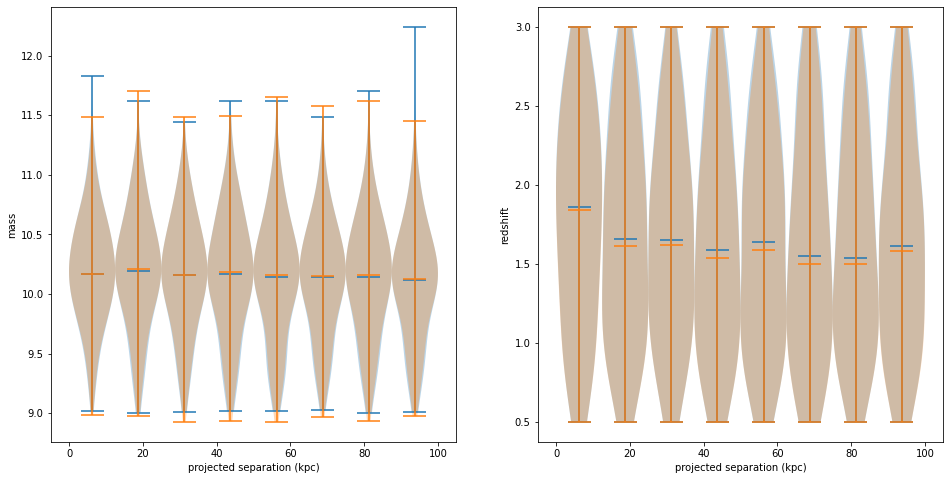

In [189]:
# make violin plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].violinplot(pmass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[0].violinplot(imass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=105)
axs[0].set_xlabel('projected separation (kpc)')
axs[0].set_ylabel('mass')

axs[1].violinplot(pz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].violinplot(iz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].axis(xmin=-5,xmax=105)
axs[1].set_xlabel('projected separation (kpc)')
axs[1].set_ylabel('redshift')

plt.show()

In [137]:
# prepare for AGN vs z plot:
AGN_z = np.concatenate(AGN_z).ravel()
AGN_LX = np.concatenate(AGN_LX).ravel()

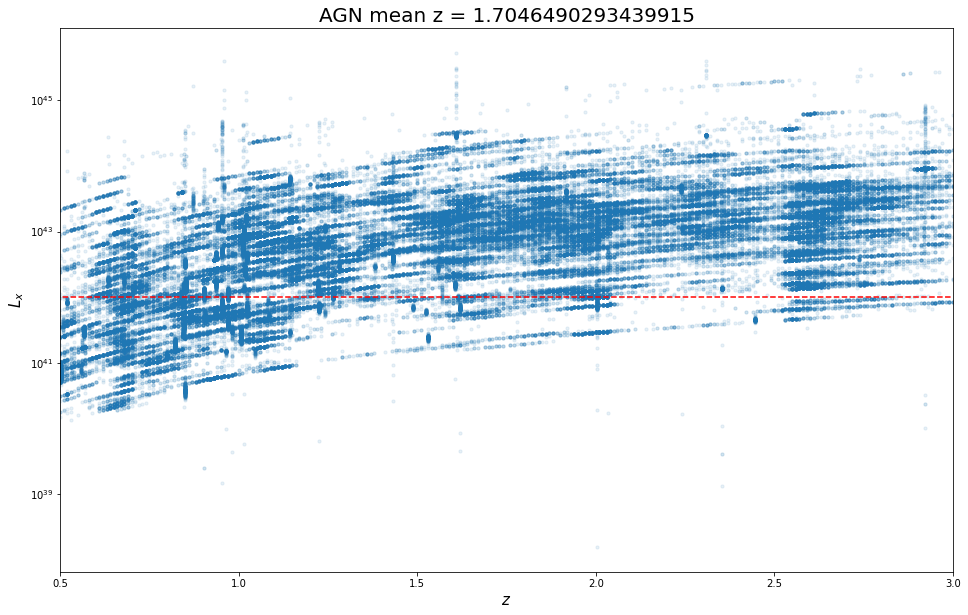

In [149]:
# plot AGN vs z
fig = plt.figure(figsize=(16,10))
plt.scatter(AGN_z, AGN_LX, s=10, alpha=0.1)
plt.yscale('log')
plt.plot((0, 3.5),(10**42,10**42), color='r', linestyle='--')
plt.xlim(0.5,3.0)
plt.title('AGN mean z = ' + str(np.mean(AGN_z[np.where(AGN_LX > 10**42)])), fontsize=20)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$L_x$', fontsize=15)
plt.show()

## Galaxy property checks

In [323]:
# For a random single iteration, plot the distribution of mass in each bin

# photo-specz_5.csv
# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
# data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
data_path2 = 'photoz_results/'


# generate a 2 random integers to look at distributions
idx = random.randint(len(os.listdir(data_path+data_path2)))
# generate bins
max_dist = 100
n_bins = 8
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# create dictionaries to store redshift and mass distributions
bin_AGN = {}
bin_pairfrac_mass = {}
bin_isofrac_mass = {}
bin_pairfrac_z = {}
bin_isofrac_z = {}

bin_pid = {}
bin_cid = {}

it_df = pd.read_csv( data_path+data_path2+(os.listdir(data_path+data_path2))[idx] )

# it_df = pd.read_csv(data_path+'photoz_results/'+file)
it_df = it_df[ (it_df['field'] != 'GDS') & (it_df['prime_drawn_M'] > 9.5)  ]
    
# separate pairs into bins
for rnge in bins:
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])

    # sort into bins
    bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]

    # print(len(bin_df[ (bin_df['prime_drawn_LX'] > 42) ]) , bin_df['prime_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_drawn_LX'] > 42) ]) , bin_df['partner_drawn_LX'].count())
    # print('-----')
    # print(len(bin_df[ (bin_df['prime_control1_drawn_LX'] > 42) ]), bin_df['prime_control1_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['prime_control2_drawn_LX'] > 42) ]), bin_df['prime_control2_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_control1_drawn_LX'] > 42) ]), bin_df['partner_control1_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_control2_drawn_LX'] > 42) ]), bin_df['partner_control2_drawn_LX'].count())
    # print('----------------------')
    
    # get pair distributions for mass and redshift in each bin
    bin_pairfrac_mass['pair_mass_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_drawn_M']), 
                                                               np.array(bin_df.loc[:, 'partner_drawn_M'])), axis=0 )
    bin_pairfrac_z['pair_z_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_drawn_z']), 
                                                               np.array(bin_df.loc[:, 'partner_drawn_z'])), axis=0 )
    bin_isofrac_mass['iso_mass_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_drawn_M']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_drawn_M']),
                                                           np.array(bin_df.loc[:, 'partner_control1_drawn_M']),
                                                           np.array(bin_df.loc[:, 'partner_control2_drawn_M'])), axis=0 )
    bin_isofrac_z['iso_z_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_drawn_z']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_drawn_z']),
                                                           np.array(bin_df.loc[:, 'partner_control1_drawn_z']),
                                                           np.array(bin_df.loc[:, 'partner_control2_drawn_z'])), axis=0 )
    bin_pid['pid_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_index']), 
                                                               np.array(bin_df.loc[:, 'partner_index'])), axis=0 )
    bin_cid['cid_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_ID']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_ID']),
                                                           np.array(bin_df.loc[:, 'partner_control1_ID']),
                                                           np.array(bin_df.loc[:, 'partner_control2_ID'])), axis=0 )


In [324]:
# aa = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'prime_index'])
# print(aa)

# bb = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'prime_control1_ID'])

# cc = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'partner_control1_ID'])
# # check for duplicate indices
# for idx in aa:
#     if idx in bb or idx in cc:
#         print('oops')

In [325]:
pmass = [ (bin_pairfrac_mass[col]) for col in bin_pairfrac_mass]
pz = [ (bin_pairfrac_z[col]) for col in bin_pairfrac_z]
imass = [ (bin_isofrac_mass[col])[~np.isnan(bin_isofrac_mass[col])] for col in bin_isofrac_mass]
iz = [ (bin_isofrac_z[col])[~np.isnan(bin_isofrac_z[col])] for col in bin_isofrac_z]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

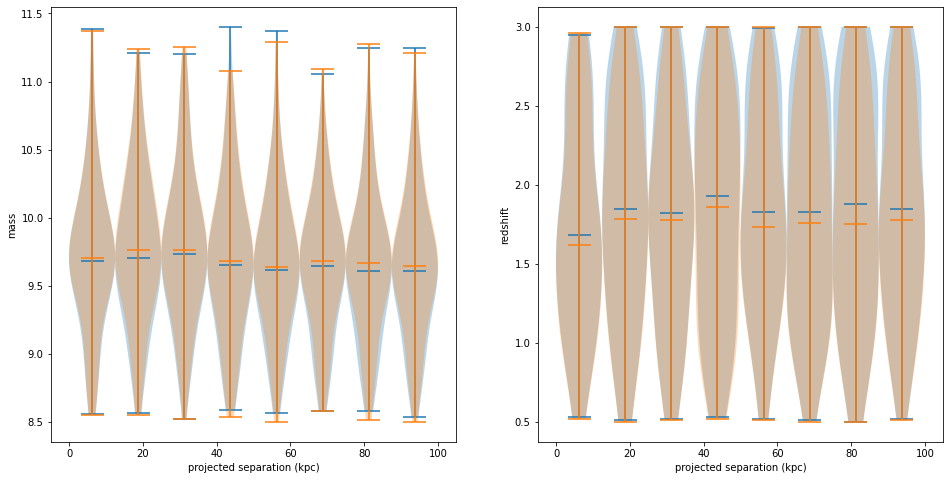

In [326]:
# make violin plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].violinplot(pmass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[0].violinplot(imass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=105)
axs[0].set_xlabel('projected separation (kpc)')
axs[0].set_ylabel('mass')

axs[1].violinplot(pz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].violinplot(iz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].axis(xmin=-5,xmax=105)
axs[1].set_xlabel('projected separation (kpc)')
axs[1].set_ylabel('redshift')

plt.show()


## Calculate AGN fractions

In [258]:
# create bins
max_dist = 100
n_bins = 8
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# define X-ray luminosity AGN limit
LX_AGN = 10**42

# create dictionaries to store AGN fractions
bin_AGN = {}
bin_pairfrac = {}
bin_isofrac = {}

# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
# data_path2 = 'photoz_results/'

# read through all the iteration files
for file in tqdm(os.listdir(data_path+data_path2)):
    it_df = pd.read_csv(data_path+data_path2+file)
    it_df = it_df[ (it_df['prime_drawn_M'] > 10) & (it_df['prime_drawn_z'] < 3.0) & (it_df['field'] != 'GDS') ]# &
                #(it_df['mass_ratio'] <= 0.40)]
        
    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])
        
        # sort into bins
        bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]
        
        # print(len(bin_df[ (bin_df['prime_drawn_LX'] > LX_AGN) ]) , bin_df['prime_drawn_LX'].count())
        # print(len(bin_df[ (bin_df['partner_drawn_LX'] > LX_AGN) ]) , bin_df['partner_drawn_LX'].count())
        # print('-----')
        # print(len(bin_df[ (bin_df['prime_control1_drawn_LX'] > LX_AGN) ]), bin_df['prime_control1_drawn_LX'].count())
        # print(len(bin_df[ (bin_df['prime_control2_drawn_LX'] > LX_AGN) ]), bin_df['prime_control2_drawn_LX'].count())
        # print(len(bin_df[ (bin_df['partner_control1_drawn_LX'] > LX_AGN) ]), bin_df['partner_control1_drawn_LX'].count())
        # print(len(bin_df[ (bin_df['partner_control2_drawn_LX'] > LX_AGN) ]), bin_df['partner_control2_drawn_LX'].count())
        # print('----------------------')
        
        
        # print(np.array(bin_df.loc[ (bin_df['prime_drawn_LX'] > LX_AGN), 'prime_cat_ID' ]))
        # print(np.array(bin_df.loc[ (bin_df['partner_drawn_LX'] > LX_AGN), 'partner_cat_ID']) )
        # print('-----')
        # print(np.array(bin_df.loc[ (bin_df['prime_control1_drawn_LX'] > LX_AGN), 'prime_control1_cat_ID' ]))
        # print(np.array(bin_df.loc[ (bin_df['prime_control2_drawn_LX'] > LX_AGN), 'prime_control2_cat_ID' ]))
        # print(np.array(bin_df.loc[ (bin_df['partner_control1_drawn_LX'] > LX_AGN), 'partner_control1_cat_ID' ]))
        # print(np.array(bin_df.loc[ (bin_df['partner_control2_drawn_LX'] > LX_AGN), 'partner_control2_cat_ID' ]))
        # print('----------------------')
        
        
        # calculate the AGN fraction in that bin and append it to same calculation accross iteration
        bin_pairfrac[bins[rnge]] = ((  len(bin_df[ (bin_df['prime_drawn_LX'] > LX_AGN) ]) +
                                             len(bin_df[ (bin_df['partner_drawn_LX'] > LX_AGN) ])
                                            ) /
                                            (  bin_df['prime_drawn_LX'].count() +
                                             bin_df['partner_drawn_LX'].count()
                                            ))
        bin_all_pairfrac[bins[rnge]].append(bin_pairfrac[bins[rnge]])

        
        bin_isofrac[bins[rnge]] = ((  len(bin_df[ (bin_df['prime_control1_drawn_LX'] > LX_AGN) ] ) +
                                            len(bin_df[ (bin_df['prime_control2_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control1_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control2_drawn_LX'] > LX_AGN) ]) 
                                           ) /
                                            (  bin_df['prime_control1_drawn_LX'].count() +
                                             bin_df['prime_control2_drawn_LX'].count() +
                                             bin_df['partner_control1_drawn_LX'].count() +
                                             bin_df['partner_control2_drawn_LX'].count() ))
        bin_all_isofrac[bins[rnge]].append(bin_isofrac[bins[rnge]])
        
        # store simple counts
        bin_AGN_count[bins[rnge]].append(len(bin_df[ (bin_df['prime_drawn_LX'] > LX_AGN) ]) +
                                             len(bin_df[ (bin_df['partner_drawn_LX'] > LX_AGN) ]))
        
        bin_gal_count[bins[rnge]].append(bin_df['prime_drawn_LX'].count() +
                                             bin_df['partner_drawn_LX'].count())

100%|██████████| 500/500 [00:36<00:00, 13.71it/s]


In [259]:
def make_bins(max_dist=100, n_bins=10):

    bin_all_AGNfrac = {}
    bin_all_isofrac = {}
    
    # create dictionaries to store AGN and pair galaxy counts -> just for paried galaxies (controls later)
    bin_AGN_count = {}
    bin_gal_count = {}

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
        # define empty lists to later append AGN fractions to
        bin_all_AGNfrac[all_bins[str(bn)]] = []
        bin_all_isofrac[all_bins[str(bn)]] = []
        bin_AGN_count[all_bins[str(bn)]] = []
        bin_gal_count[all_bins[str(bn)]] = []
        
    
    return all_bins, bin_all_AGNfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count

In [260]:
# create dataframes from the dictionaries:
pAGNf_df = pd.DataFrame.from_dict(bin_all_pairfrac)
iAGNf_df = pd.DataFrame.from_dict(bin_all_isofrac)

In [261]:
pAGNf_df.describe()

,0.0-12.5,12.5-25.0,25.0-37.5,37.5-50.0,50.0-62.5,62.5-75.0,75.0-87.5,87.5-100.0
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.069962,0.067389,0.042539,0.051080,0.052838,0.025943,0.059701,0.039506
std,0.021795,0.012131,0.013107,0.015680,0.013101,0.009519,0.011988,0.010674
min,0.019231,0.034483,0.012658,0.005952,0.022989,0.000000,0.029126,0.008696
25%,0.055556,0.058824,0.032868,0.040000,0.043637,0.019231,0.051107,0.032370
50%,0.067568,0.067073,0.042105,0.050000,0.052758,0.025253,0.059140,0.039130
75%,0.081081,0.074713,0.051948,0.061728,0.061244,0.032147,0.067010,0.046875
max,0.148148,0.115385,0.087838,0.109589,0.098901,0.055556,0.095238,0.068548


In [262]:
iAGNf_df.describe()

,0.0-12.5,12.5-25.0,25.0-37.5,37.5-50.0,50.0-62.5,62.5-75.0,75.0-87.5,87.5-100.0
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.043239,0.046159,0.039167,0.040773,0.032653,0.037948,0.036135,0.029214
std,0.018597,0.010814,0.010662,0.011016,0.009325,0.009826,0.008381,0.007481
min,0.000000,0.014706,0.010490,0.015810,0.007937,0.008596,0.016854,0.011111
25%,0.030612,0.038648,0.031780,0.033203,0.026297,0.031062,0.029663,0.023479
50%,0.042735,0.046076,0.039084,0.040407,0.032636,0.037850,0.036601,0.028942
75%,0.054545,0.053345,0.045977,0.047857,0.038867,0.044129,0.042158,0.034263
max,0.123967,0.083333,0.070513,0.070671,0.068323,0.082324,0.063131,0.055825


In [263]:
### photo ###
#0.030469	0.017197	0.014310	0.017071	0.017050	0.012333	0.014314	0.011376
#0.030444	0.016769	0.014832	0.017431	0.018136	0.011767	0.014715	0.011397
### photo+spec ###
#0.024890	0.015904	0.012903	0.014925	0.016148	0.011903	0.013837	0.010741
#0.023732	0.014565	0.013229	0.016505	0.016001	0.011962	0.014264	0.010781

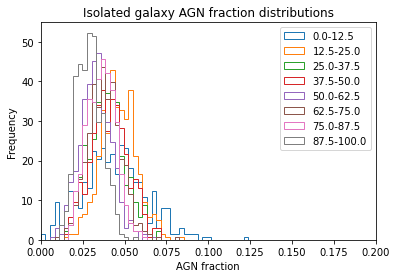

In [264]:
# plot distributions
iAGNf_df.plot.hist(bins=45, histtype='step', density=True)

plt.title('Isolated galaxy AGN fraction distributions')
plt.xlabel('AGN fraction')
plt.xlim(0, 0.2)
plt.show()

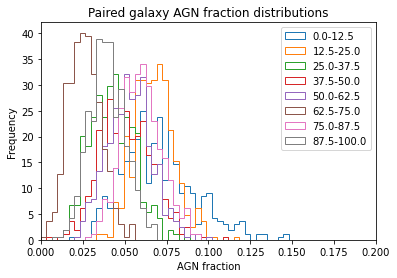

In [265]:
pAGNf_df.plot.hist(bins=45, histtype='step', density=True)
plt.xlim(0, 0.20)
plt.title('Paired galaxy AGN fraction distributions')
plt.xlabel('AGN fraction')
plt.show()

In [266]:
# make AGN fraction vectors
pdata = [pAGNf_df[col] for col in pAGNf_df]
idata = [iAGNf_df[col] for col in pAGNf_df]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

# make an AGN enhancment vector
# quick way to get rid of dividing by 0 issue, will need to address later

for j in range(0,len(idata)):
    for k in range(0, len(idata[j])):
        if idata[j][k] == 0:
            idata[j][k] = 1000
            
for j in range(0,len(idata)):
    for k in range(0, len(idata[j])):
        if idata[j][k] == 1000:            
            idata[j][k] = min(idata[j])
            print('here')
        


AGN_enh = [(pdata[i] / idata[i]) for i in range(0, len(pdata))]

# should make some dynamic vector in case I want to increase pair sample out to 150 kpc or something

here
here


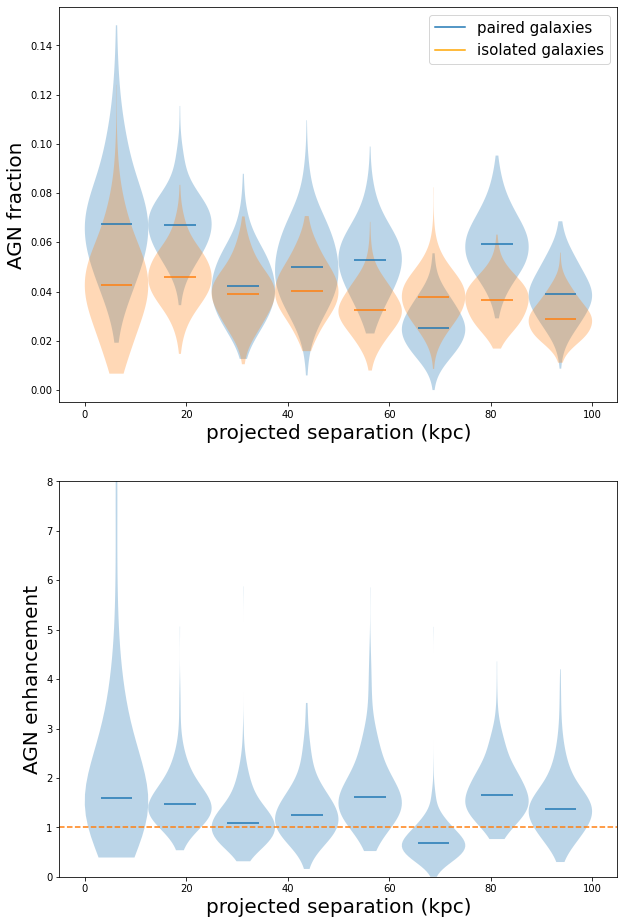

In [267]:
# make violin plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))
axs[0].violinplot(pdata, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
axs[0].violinplot(idata, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=105)
axs[0].axis(ymin=-0.005)
axs[0].set_xlabel('projected separation (kpc)', fontsize=20)
axs[0].set_ylabel('AGN fraction', fontsize=20)
axs[0].plot([-10,-10], color='#1f77b4', label='paired galaxies')
axs[0].plot([-10,-10], color='orange', label='isolated galaxies')
axs[0].legend(fontsize=15)

axs[1].violinplot(AGN_enh, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
axs[1].plot([-5,105], [1,1], linestyle='--')
axs[1].axis(xmin=-5,xmax=105)
axs[1].axis(ymin=0, ymax=8)
axs[1].set_xlabel('projected separation (kpc)', fontsize=20)
axs[1].set_ylabel('AGN enhancement', fontsize=20)

plt.show()



In [268]:
# show average out counts from the bins and output as a simple df
# copy the bin_gal_count distributions to use later
bin_gal_count_copy = bin_gal_count.copy()
for rnge in bins:
    bin_AGN_count[str(bins[rnge])] = [np.mean(bin_AGN_count[str(bins[rnge])])]
    bin_gal_count[str(bins[rnge])] = [np.mean(bin_gal_count[str(bins[rnge])])]
# print(bin_gal_count)
AGN_count_df = pd.DataFrame.from_dict(bin_AGN_count)
gal_count_df = pd.DataFrame.from_dict(bin_gal_count)
df = pd.concat([AGN_count_df,gal_count_df], ignore_index = True, axis=0)
df.rename(index={0: 'mean AGN count', 1: 'mean paired gals count'})


,0.0-12.5,12.5-25.0,25.0-37.5,37.5-50.0,50.0-62.5,62.5-75.0,75.0-87.5,87.5-100.0
mean AGN count,4.310,10.882,6.834,7.88,9.568,5.146,12.528,9.270
mean paired gals count,62.056,162.152,161.060,154.74,181.316,198.472,210.272,234.792


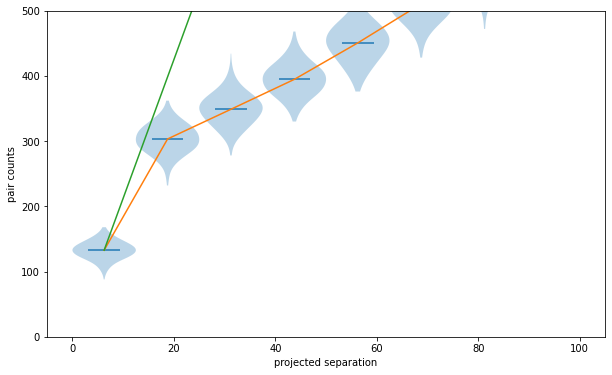

In [246]:
# fit data to natural scaling of areas of successive disks
ra = max_dist / n_bins
rn = np.arange(0,max_dist+max_dist/n_bins,max_dist/n_bins)
# create a list to store scaled pair numbers
np_scaled = []
# number of pairs in the inner circle -> do just the median now
np_a = df[bins['0']].iloc[1]
for n in range(0, len(bins)+1): 
    # Area ratio to center circle
    pnA = ( (n*ra)**2 - ((n-1)*ra)**2 ) / (ra**2)
    np_scaled.append(pnA*np_a)
# plt.plot(rn,np_a)

# I don't this will be helpful, we can plot them 
pcdata = [bin_gal_count_copy[col] for col in bin_gal_count_copy]
pair_counts = df.iloc[1].to_numpy()
fig = plt.figure(figsize=(10,6))

plt.violinplot(pcdata, kpc_meds, points=100, widths=vwidth, showmeans=True,
                     showextrema=False, showmedians=False, bw_method=0.5)
plt.plot(kpc_meds, pair_counts)
plt.plot(kpc_meds, np_scaled[1:])
plt.xlabel('projected separation')
plt.ylabel('pair counts')
plt.ylim(0,500)

plt.show()

In [204]:
it_df.loc[it_df['mass_ratio'] < 0.4]

,Unnamed: 0,prime_index,partner_index,arc_sep,mass_ratio,dv,kpc_sep,prime_drawn_z,prime_drawn_M,prime_drawn_LX,partner_drawn_z,partner_drawn_M,partner_drawn_LX,prime_control1_ID,prime_control1_drawn_z,prime_control1_drawn_M,prime_control1_drawn_LX,prime_control2_ID,prime_control2_drawn_z,prime_control2_drawn_M,prime_control2_drawn_LX,partner_control1_ID,partner_control1_drawn_z,partner_control1_drawn_M,partner_control1_drawn_LX,partner_control2_ID,partner_control2_drawn_z,partner_control2_drawn_M,partner_control2_drawn_LX,field,prime_cat_ID,partner_cat_ID,prime_control1_cat_ID,prime_control2_cat_ID,partner_control1_cat_ID,partner_control2_cat_ID
2249,22243,755,947,4.757016,0.334400,0.000000,39.476474,2.14,10.567600,-1.698106e+60,2.14,10.233200,-1.698106e+60,2697.0,2.13,10.566100,-1.682010e+60,6268.0,2.16,10.568500,-1.730506e+60,18820.0,2.14,10.247000,1.068092e+43,19208.0,2.13,10.213500,-1.682010e+60,EGS,1590,1880,4435.0,9515.0,27785.0,28610.0
2258,26374,879,1165,8.967304,0.162600,0.000000,75.321599,1.93,10.688800,-1.374870e+60,1.93,10.526200,-1.374870e+60,11829.0,1.94,10.709000,-1.389551e+60,9084.0,1.91,10.701200,-1.345724e+60,15133.0,1.89,10.480700,-1.316867e+60,17051.0,1.96,10.472600,-1.419128e+60,EGS,1780,2206,17697.0,13703.0,22525.0,25283.0
2361,60925,1917,1866,1.490052,0.347800,632.982967,12.563354,1.40,10.953200,-7.029476e+59,1.39,10.605400,-6.923361e+59,17297.0,1.40,10.913000,-7.029476e+59,17263.0,1.36,10.958600,-6.609752e+59,2420.0,1.40,10.607500,-7.029476e+59,3555.0,1.41,10.599200,-7.136379e+59,EGS,3333,3255,25636.0,25588.0,4054.0,5642.0
2441,84790,2578,2794,5.592369,0.203100,0.000000,43.664294,2.86,10.319700,-3.032875e+60,2.86,10.116600,-3.032875e+60,9399.0,2.87,10.321400,-3.053763e+60,1924.0,2.89,10.327400,-3.095726e+60,3368.0,2.94,10.155000,1.459481e+44,11614.0,2.96,10.090700,-3.244538e+60,EGS,4270,4574,14167.0,3345.0,5375.0,17393.0
2581,127049,3660,3133,12.071007,0.099600,-964.659583,96.432795,0.99,10.187500,-3.337793e+59,1.00,10.087900,-3.411487e+59,19182.0,0.98,10.189800,-3.264928e+59,10305.0,1.00,10.206200,-3.411487e+59,5523.0,0.99,10.076800,-3.337793e+59,9069.0,1.01,10.065500,-3.486010e+59,EGS,5798,5047,28553.0,15473.0,8438.0,13679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,655257,19074,19524,10.000356,0.182340,-891.385929,84.557206,1.75,11.075547,-1.123047e+60,1.77,10.893207,-1.149852e+60,1393.0,1.74,11.033424,9.900364e+42,11264.0,1.78,11.130334,-1.163366e+60,11018.0,1.78,10.899821,6.246925e+43,18553.0,1.76,10.913814,-1.136413e+60,UDS,26531,27125,2067.0,15548.0,15222.0,25778.0
10248,658061,19163,17255,11.326784,0.248642,-770.187101,89.201885,2.77,10.369216,-2.847684e+60,2.81,10.120574,-2.929366e+60,14502.0,2.74,10.372912,-2.787083e+60,17202.0,2.81,10.376577,-2.929366e+60,18387.0,2.79,10.110590,-2.888400e+60,17595.0,2.85,10.089905,-3.012048e+60,UDS,26645,23857,20011.0,23763.0,25533.0,24388.0
10250,658453,19176,19469,10.776766,0.364120,0.000000,66.473880,0.51,10.152288,-7.784723e+58,0.51,9.788168,-7.784723e+58,18472.0,0.51,10.184691,-7.784723e+58,7606.0,0.50,10.198657,-7.452899e+58,8660.0,0.51,9.790988,-7.784723e+58,1443.0,0.50,9.795185,-7.452899e+58,UDS,26663,27049,25651.0,10620.0,11994.0,2143.0
10256,659760,19222,19178,3.331600,0.289502,933.409991,26.860571,1.03,10.931966,-3.637540e+59,1.02,10.642465,-3.561361e+59,3383.0,1.00,10.954725,-3.411487e+59,10346.0,0.98,10.957128,-3.264928e+59,13355.0,1.05,10.660865,-3.792378e+59,15483.0,1.05,10.622214,-3.792378e+59,UDS,26717,26665,4836.0,14290.0,18388.0,21385.0


In [205]:
# right now there is not evidence for AGN enhancement
# a few things:
## write code to account for pairs where a partner falls below a mass limit
### simply just say that the prime needs to be greater that 8.5, and any partner needs to be within a mass ratio limit

## seal with duplicate issue where mass ratio = 0, currently some unaccounted for duplicates

## control sampe not exactly representative of the pair sample

## currently, we are using zhi and low values for the mFDa approach, which is not consistent with the draws
### additionally, these are 68% confidence intervals
### will be solved when Dale sends more data
#   - could try making the dz threshold lower
#   - why are the pairs at higher z than expected?
#   - could be the result of poor zhi / zlow cuts (could run one iteration to find out

## could be worth correcting all of the pd warnings now that I fully understand loc...
#   - thought I fixed this but nope

## galaxy duplicate issue in counting AGN -> should be fixed in this code ^
#   - okay but don't we want to not do this before making bin cuts? perhaps it is just safest to select the closest pair
#   - in binning the prime galaxy and include the partner galaxies where in their own bins?
#   - ask Chris what we should do


# let's say the current version of the code is version 1.0
# these tasts will be implemented as different versions


In [154]:
# major issue now is that ID's appear in both the pair and control samples
# could be due to missuse of loc and iloc
# incorrect definitions for pair_df or iso_df

## Create Composite Photo-Z PDF's

In [207]:
# this will only work for photo-z draw only right now
# will need to include some kind of spec-z flag
fields = ['GOODSS','EGS','COSMOS','GOODSN','UDS']
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

pair_means_all = {}
control_means_all = {}

for key in bins:
    pair_means_all[bins[key]] = np.zeros((81, len(os.listdir(data_path+'photoz_results/'))))
    control_means_all[bins[key]] = np.zeros((81, len(os.listdir(data_path+'photoz_results/'))))

# generate a list of all filenames:
file_list = []
for idx in range(0, len(os.listdir(data_path+'photoz_results/'))):
    file = data_path+'photoz_results/'+(os.listdir(data_path+'photoz_results/'))[idx]
    file_list.append(file)
    
# Create a multiprocessing Pool
pool = Pool()  
# process fields iterable with pool -> parallelize code by field
    
all_data = pool.map(composite_PDFs, file_list)
    
# close pool
pool.close()
pool.join()


In [208]:
# analyze output data and create composite PDFs
# create dictionaries to store means of all iterations
mean_comp_pair_all = {}
mean_comp_control_all = {}

for i in range(0, len(all_data)):
    it = all_data[i]
    pair_dict = it[0]
    control_dict = it[1]
    
    for key in bins:
        pair_means_all[bins[key]][:,i] = pair_dict[bins[key]]
        control_means_all[bins[key]][:,i] = control_dict[bins[key]]
        
# now take means of all the means of each iteration     
for key in bins:
    mean_comp_pair_all[bins[key]] = np.mean(pair_means_all[bins[key]], axis=1)
    mean_comp_control_all[bins[key]] = np.mean(control_means_all[bins[key]], axis=1)


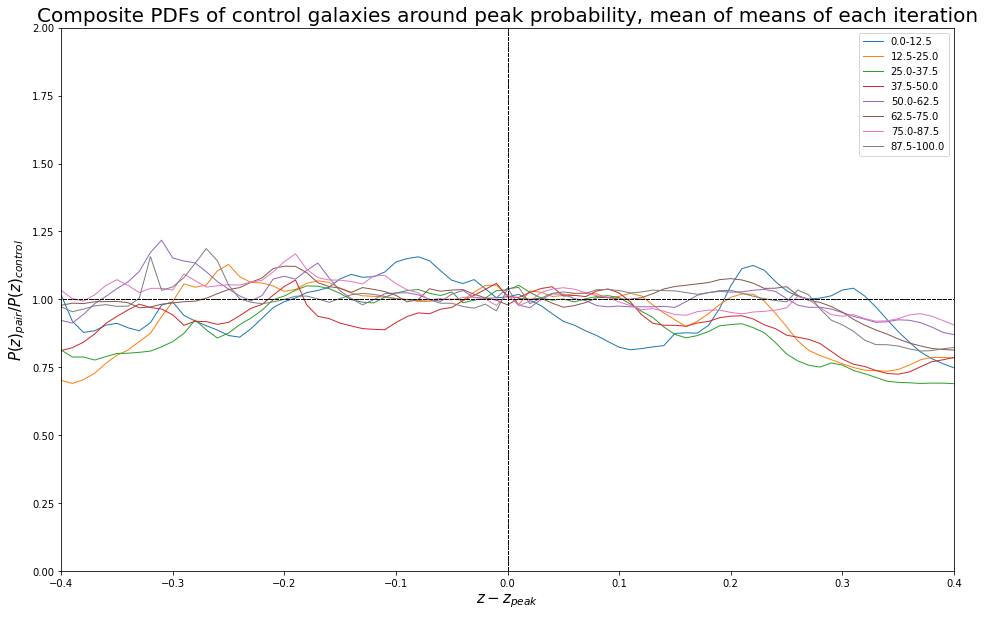

In [209]:
# finally plot
fig = plt.figure(figsize=(16,10))
comp_z = np.arange(-0.4, 0.41, 0.01)

for key in mean_comp_pair_all:
    plt.plot(comp_z, mean_comp_pair_all[key] / mean_comp_control_all[key], label=key, linewidth=1)
    plt.plot([-1,1],[1,1], c='black', linestyle='--', linewidth=1)
    plt.plot([0,0],[-5,5], c='black', linestyle='--', linewidth=1)
    # plt.plot(comp_z, mean_comp_control_all[key], label=key, linewidth=1)
    
    ### seems to be something goin on here... ###
    ### no reason why the PDF widths should be so correlated between pair and control ###

plt.legend(fontsize=10)
plt.xlabel('$z-z_{peak}$', fontsize=15)
plt.ylabel('$P(z)_{pair} / P(z)_{control}$', fontsize=15)
plt.title('Composite PDFs of control galaxies around peak probability, mean of means of each iteration', fontsize=20)
plt.xlim(-0.4,0.4)
plt.ylim(0,2)

# plt.xlim(-0.1,0.1)
plt.show()

In [206]:
# make this into a function:
def composite_PDFs(file):

    # take a similar approach as plotting pair/control mass/z distributions but also sort into bins
    # prime_cat_ID	partner_cat_ID	prime_control1_cat_ID	
    # prime_control2_cat_ID	partner_control1_cat_ID	partner_control2_cat_ID

    # create bins -> constants should be the same as when AGN fraction is calculated, so might as well comment out
    max_dist = 100
    n_bins = 8

    # load the random iteration
    ran_df = pd.read_csv(file)
    ran_df = ran_df[ (ran_df['prime_drawn_M'] > 10) & (ran_df['prime_drawn_z'] < 3.0) & (ran_df['field'] != 'GDS') ]
    ran_df = ran_df.fillna('666666666')

    # change field string names and ID so that the filenames can easily be created:
    # do ID first... this was designed kinda poorly on my part...
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 1, 
               'prime_cat_ID' ] = '0000'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 2, 
               'prime_cat_ID' ] = '000'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 3, 
               'prime_cat_ID' ] = '00'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 4, 
               'prime_cat_ID' ] = '0'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 5, 
               'prime_cat_ID' ] = (ran_df['prime_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 1, 
               'partner_cat_ID' ] = '0000'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 2, 
               'partner_cat_ID' ] = '000'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 3, 
               'partner_cat_ID' ] = '00'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 4, 
               'partner_cat_ID' ] = '0'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 5, 
               'partner_cat_ID' ] = (ran_df['partner_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'prime_control1_cat_ID' ] = '0000'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'prime_control1_cat_ID' ] = '000'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'prime_control1_cat_ID' ] = '00'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'prime_control1_cat_ID' ] = '0'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'prime_control1_cat_ID' ] = (ran_df['prime_control1_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'prime_control2_cat_ID' ] = '0000'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'prime_control2_cat_ID' ] = '000'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'prime_control2_cat_ID' ] = '00'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'prime_control2_cat_ID' ] = '0'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'prime_control2_cat_ID' ] = (ran_df['prime_control2_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'partner_control1_cat_ID' ] = '0000'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'partner_control1_cat_ID' ] = '000'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'partner_control1_cat_ID' ] = '00'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'partner_control1_cat_ID' ] = '0'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'partner_control1_cat_ID' ] = (ran_df['partner_control1_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'partner_control2_cat_ID' ] = '0000'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'partner_control2_cat_ID' ] = '000'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'partner_control2_cat_ID' ] = '00'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'partner_control2_cat_ID' ] = '0'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'partner_control2_cat_ID' ] = (ran_df['partner_control2_cat_ID'].astype(int)).astype(str)


    # now simply the field names
    ran_df.loc[ (ran_df['field'] == 'GDS'), 'field' ] = 'GOODSS'
    ran_df.loc[ (ran_df['field'] == 'COS'), 'field' ] = 'COSMOS'
    ran_df.loc[ (ran_df['field'] == 'GDN'), 'field' ] = 'GOODSN'


    ran_df['PR_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_cat_ID']+'.pzd'
    ran_df['PA_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_cat_ID']+'.pzd'
    ran_df['PRC1_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_control1_cat_ID']+'.pzd'
    ran_df['PRC2_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_control2_cat_ID']+'.pzd'
    ran_df['PAC1_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_control1_cat_ID']+'.pzd'
    ran_df['PAC2_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_control2_cat_ID']+'.pzd'


    # create a dictionary to store the CANDELS ID + field as the PDF filenames
    bin_pair = {}
    bin_control = {}

    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = ran_df[ (ran_df['kpc_sep'] > low) & (ran_df['kpc_sep'] <= high) ]

        # create lists of the filenames for each bin and drop nan names
        PR_file = np.array(bin_df['PR_PDF_filename'])
        PA_file = np.array(bin_df['PA_PDF_filename'])
        PRC1_file = np.array(bin_df['PRC1_PDF_filename'])
        PRC2_file = np.array(bin_df['PRC2_PDF_filename'])
        PAC1_file = np.array(bin_df['PAC1_PDF_filename'])
        PAC2_file = np.array(bin_df['PAC2_PDF_filename'])
        pairs_file_all = np.concatenate((PR_file, PA_file), axis=0)
        control_file_all = np.concatenate((PRC1_file, PRC2_file, PAC1_file, PAC2_file), axis=0)

        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_GOODSS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_EGS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_COSMOS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_GOODSN_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_UDS_ID666666666.pzd')] = np.nan

        cleaned_control = np.array([x for x in control_file_all if str(x) != 'nan'])

        bin_pair[bins[rnge]] = pairs_file_all
        bin_control[bins[rnge]] = cleaned_control
        
   # -------------------------------------------------------------------------------------------------------#

   # create a dictionary to store the composites of all of them
    comp_all_pair = {}
    comp_all_control = {}

    for key in bin_pair:
        # fig = plt.figure(figsize=[10,10])
        # plt.title(key)

        # create an array to store the composites for all the gal in this bin
        # will want to select values z_peak +/- 0.5
        comp_bin_pair = np.zeros((81, len(bin_pair[key])))
        comp_bin_control = np.zeros((81, len(bin_control[key])))

        for i, file in enumerate(bin_pair[key]):
            # identify fields based on filename and define z_peak
            file_field_end = file[-15:-12]
            if file_field_end == 'DSS': 
                file_field = 'GOODSS'
                z_peak = float(GDSz_cat.loc[ (GDSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'EGS': 
                file_field = 'EGS'
                z_peak = float(EGSz_cat.loc[ (EGSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'MOS': 
                file_field = 'COSMOS'
                z_peak = float(COSz_cat.loc[ (COSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'DSN': 
                file_field = 'GOODSN'
                z_peak = float(GDNz_cat.loc[ (GDNz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'UDS': 
                file_field = 'UDS'
                z_peak = float(UDSz_cat.loc[ (UDSz_cat['file'] == file), 'HB4_z_peak' ])
            # open PDF for this file:
            pdf_filename = '/nobackup/c1029594/CANDELS_AGN_merger_data/Data - All Fields/'+file_field+'_OPTIMIZED03/'+file
            pdf = pd.read_csv(pdf_filename, comment='#', names=['z', 'Finkelstein', 'Fontana', 'Pforr', 'Salvato', 'Wiklind',
                                                      'Wuyts', 'HB4', 'mFDa4'], delimiter=' ')

            pdf['z_adj'] = pdf['z'] - z_peak

            # select the HB4 values where z is 0.5 within the z_peak
            upper = pdf.loc[ (pdf['z_adj'] < 0.401) & (pdf['z_adj'] >= 0), 'HB4' ] 
            lower = pdf.loc[ (pdf['z_adj'] > -0.401) & (pdf['z_adj'] < 0), 'HB4' ] 
            comp_bin_pair[40:(40+len(upper)),i] = upper
            comp_bin_pair[(40-len(lower)):40,i] = lower


            # subtract z_peak from all the z values in pdf
            # plt.plot(pdf['z_adj'], pdf['HB4'], color='g', alpha=0.1)    
            # plt.xlim(-0.5,0.5)
            # plt.xlabel('z')

        # Now for the control galaxies
        for j, file in enumerate(bin_control[key]):
            # identify fields based on filename and define z_peak
            file_field_end = file[-15:-12]
            if file_field_end == 'DSS': 
                file_field = 'GOODSS'
                z_peak = float(GDSz_cat.loc[ (GDSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'EGS': 
                file_field = 'EGS'
                z_peak = float(EGSz_cat.loc[ (EGSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'MOS': 
                file_field = 'COSMOS'
                z_peak = float(COSz_cat.loc[ (COSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'DSN': 
                file_field = 'GOODSN'
                z_peak = float(GDNz_cat.loc[ (GDNz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'UDS': 
                file_field = 'UDS'
                z_peak = float(UDSz_cat.loc[ (UDSz_cat['file'] == file), 'HB4_z_peak' ])
            # open PDF for this file:
            pdf_filename = '/nobackup/c1029594/CANDELS_AGN_merger_data/Data - All Fields/'+file_field+'_OPTIMIZED03/'+file
            pdf = pd.read_csv(pdf_filename, comment='#', names=['z', 'Finkelstein', 'Fontana', 'Pforr', 'Salvato', 'Wiklind',
                                                      'Wuyts', 'HB4', 'mFDa4'], delimiter=' ')

            pdf['z_adj'] = pdf['z'] - z_peak

            # select the HB4 values where z is 0.5 within the z_peak
            upper = pdf.loc[ (pdf['z_adj'] < 0.401) & (pdf['z_adj'] >= 0), 'HB4' ] 
            lower = pdf.loc[ (pdf['z_adj'] > -0.401) & (pdf['z_adj'] < 0), 'HB4' ] 
            comp_bin_control[40:(40+len(upper)),j] = upper
            comp_bin_control[(40-len(lower)):40,j] = lower

        mean_comp_pair = np.mean(comp_bin_pair, axis=1)
        mean_comp_control = np.mean(comp_bin_control, axis=1)

        comp_all_pair[key] = mean_comp_pair
        comp_all_control[key] = mean_comp_control


        #     plt.plot(comp_z, mean_comp, color='r')   
        #     plt.show()
        
    return comp_all_pair, comp_all_control


In [358]:
# control_file_all

In [69]:
# Okay I have the pair and control filenames in each bin, so now I'll just have to load them and overplot
# load in the redshift catalogs for each field]
zPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/Pair Project - Updated Data/redshift_catalogs.full/'

GDSz_cat = pd.read_csv(zPATH+'zcat_GOODSS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
EGSz_cat = pd.read_csv(zPATH+'zcat_EGS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
COSz_cat = pd.read_csv(zPATH+'zcat_COSMOS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
GDNz_cat = pd.read_csv(zPATH+'zcat_GOODSN_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
UDSz_cat = pd.read_csv(zPATH+'zcat_UDS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')

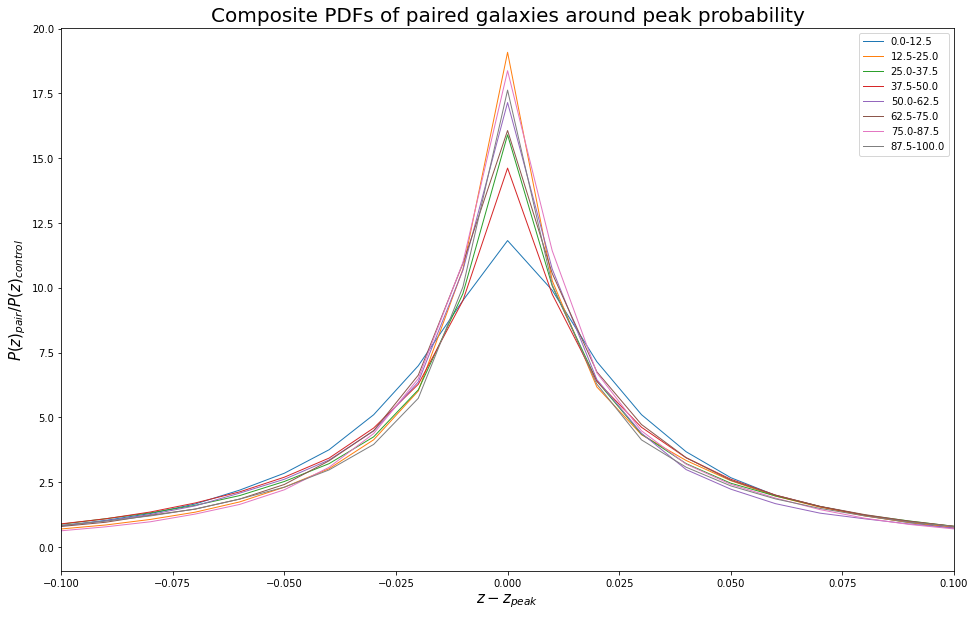

In [374]:
fig = plt.figure(figsize=(16,10))
comp_z = np.arange(-0.4, 0.41, 0.01)

for key in comp_all_pair:
    # plt.plot(comp_z, comp_all_pair[key] / comp_all_control[key], label=key, linewidth=1)
    # plt.plot([-1,1],[1,1], c='black', linestyle='--', linewidth=1)
    # plt.plot([0,0],[-5,5], c='black', linestyle='--', linewidth=1)
    plt.plot(comp_z, comp_all_control[key], label=key, linewidth=1)
    
    ### seems to be something goin on here... ###
    ### no reason why the PDF widths should be so correlated between pair and control ###

plt.legend(fontsize=10)
plt.xlabel('$z-z_{peak}$', fontsize=15)
plt.ylabel('$P(z)_{pair} / P(z)_{control}$', fontsize=15)
plt.title('Composite PDFs of paired galaxies around peak probability', fontsize=20)
# plt.xlim(-0.4,0.4)
# plt.ylim(0,2)

plt.xlim(-0.1,0.1)
plt.show()

In [362]:
# (len((ran_df['prime_cat_ID'].astype(int)).astype(str))) == 1
# ran_df.loc[ (pd.isna(ran_df['prime_control1_cat_ID']) == False) & ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1)]

# new idea is to turn every nan value in the DF to '666666666' okay let's rock
ran_df4 = ran_df.fillna(66666666)
ran_df

,Unnamed: 0,prime_index,partner_index,arc_sep,mass_ratio,dv,kpc_sep,prime_drawn_z,prime_drawn_M,prime_drawn_LX,partner_drawn_z,partner_drawn_M,partner_drawn_LX,prime_control1_ID,prime_control1_drawn_z,prime_control1_drawn_M,prime_control1_drawn_LX,prime_control2_ID,prime_control2_drawn_z,prime_control2_drawn_M,prime_control2_drawn_LX,partner_control1_ID,partner_control1_drawn_z,partner_control1_drawn_M,partner_control1_drawn_LX,partner_control2_ID,partner_control2_drawn_z,partner_control2_drawn_M,partner_control2_drawn_LX,field,prime_cat_ID,partner_cat_ID,prime_control1_cat_ID,prime_control2_cat_ID,partner_control1_cat_ID,partner_control2_cat_ID,PR_PDF_filename,PA_PDF_filename,PRC1_PDF_filename,PRC2_PDF_filename,PAC1_PDF_filename,PAC2_PDF_filename
1,489,31,35,6.907845,0.980000,-837.651944,56.640832,1.12,10.130000,-6.844061e+59,1.13,9.150000,-6.996281e+59,11448,1.13,10.14,-6.99628e+59,1968,1.11,10.16,-6.69384e+59,13578,1.16,9.16,-7.46499e+59,6948,1.14,9.12,-7.1505e+59,GOODSS,00040,00044,17245,02793,20534,10246,ALL_OPTIMIZED_PDFS_GOODSS_ID00040.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00044.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID17245.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID02793.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID20534.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID10246.pzd
2,493,31,39,8.168008,0.890000,-837.651944,66.973525,1.12,10.130000,-6.844061e+59,1.13,9.240000,-6.996281e+59,9757,1.09,10.11,-6.39934e+59,9318,1.08,10.12,-6.25506e+59,11503,1.15,9.2,-7.30674e+59,694,1.15,9.2,-7.30674e+59,GOODSS,00040,00050,14637,13941,17325,00953,ALL_OPTIMIZED_PDFS_GOODSS_ID00040.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00050.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID14637.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID13941.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID17325.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00953.pzd
26,7324,316,232,11.991756,0.280000,387.877225,94.259811,2.79,10.050000,-6.424522e+60,2.77,9.770000,-6.313885e+60,2940,2.8,10.04,-6.48025e+60,10353,2.79,10.02,-6.42452e+60,666666666,666666666,666666666,666666666,666666666,666666666,666666666,666666666,GOODSS,00423,00308,04172,15555,666666666,666666666,ALL_OPTIMIZED_PDFS_GOODSS_ID00423.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00308.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID04172.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID15555.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID666666666.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID666666666.pzd
44,10572,442,477,14.426783,0.840000,0.000000,94.919326,0.58,10.130000,-1.359550e+59,0.58,9.290000,-1.359550e+59,4460,0.56,10.13,-1.24887e+59,212,0.57,10.16,-1.30349e+59,11592,0.58,9.33,-1.35955e+59,8415,0.58,9.33,-1.35955e+59,GOODSS,00606,00652,06497,00278,17453,12508,ALL_OPTIMIZED_PDFS_GOODSS_ID00606.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00652.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID06497.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00278.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID17453.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID12508.pzd
47,11487,480,457,7.445339,0.700000,-682.636838,57.681151,2.94,10.570000,-7.289205e+60,2.98,9.870000,-7.530259e+60,11053,2.94,10.6,-7.2892e+60,102,2.98,10.56,-7.53026e+60,10484,2.99,9.86,-7.59122e+60,1141,3,9.81,-7.65245e+60,GOODSS,00655,00624,16671,00139,15760,01604,ALL_OPTIMIZED_PDFS_GOODSS_ID00655.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00624.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID16671.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID00139.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID15760.pzd,ALL_OPTIMIZED_PDFS_GOODSS_ID01604.pzd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10193,655769,19139,18859,10.736389,0.866994,-515.311497,90.950927,1.60,10.380211,-1.652675e+60,1.61,9.513218,-1.678249e+60,16718,1.55,10.3927,-1.52824e+60,16939,1.54,10.3522,-1.50403e+60,11213,1.6,9.49276,-1.65268e+60,17144,1.59,9.54407,-1.62733e+60,UDS,26636,26237,23116,23447,15496,23733,ALL_OPTIMIZED_PDFS_UDS_ID26636.pzd,ALL_OPTIMIZED_PDFS_UDS_ID26237.pzd,ALL_OPTIMIZED_PDFS_UDS_ID23116.pzd,ALL_OPTIMIZED_PDFS_UDS_ID23447.pzd,ALL_OPTIMIZED_PDFS_UDS_ID15496.pzd,ALL_OPTIMIZED_PDFS_UDS_ID23733.pzd
10194,655775,19139,19052,2.929786,0.327133,0.000000,2

In [70]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # modified version of make_bins that doesn't care about AGN fractions

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [329]:
# check if they are duplicate:
for rnge in bins:
    aa = comp_all_pair[bins[rnge]]
    bb = comp_all_control[bins[rnge]]
    for idx in aa:
        if idx in bb:
            print('fuck')

In [363]:
print(idx)

429
